# Objective

**Tune and choose the time series model to forecast the crime counts of THEFT and ASSAULT for the next 6 months. Use the forecast result to help Chicago law enforcement to allocate resources.**

# Import Packages and Custom Function

In [1]:
# Load necessary packages 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
import glob
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
import pmdarima as pm

In [2]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [3]:
# Custom function for plotting ACF and PACF
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [4]:
# Custom function to plot forecast
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [5]:
# Custom function for model evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

---

# Load and Combine Datasets

In [6]:
# # Set the path to the directory containing  CSV files
csv_files_path = 'Data/*.csv'
# Use the glob module to get a list of all CSV files in the specified directory
csv_file = glob.glob(csv_files_path)
csv_file

['Data/Chicago-Crime_2019.csv',
 'Data/Chicago-Crime_2018.csv',
 'Data/Chicago-Crime_2008.csv',
 'Data/Chicago-Crime_2020.csv',
 'Data/Chicago-Crime_2021.csv',
 'Data/Chicago-Crime_2009.csv',
 'Data/Chicago-Crime_2022.csv',
 'Data/Chicago-Crime_2007.csv',
 'Data/Chicago-Crime_2013.csv',
 'Data/Chicago-Crime_2012.csv',
 'Data/Chicago-Crime_2006.csv',
 'Data/Chicago-Crime_2010.csv',
 'Data/Chicago-Crime_2004.csv',
 'Data/Chicago-Crime_2005.csv',
 'Data/Chicago-Crime_2011.csv',
 'Data/Chicago-Crime_2015.csv',
 'Data/Chicago-Crime_2001.csv',
 'Data/Chicago-Crime_2014.csv',
 'Data/Chicago-Crime_2002.csv',
 'Data/Chicago-Crime_2016.csv',
 'Data/Chicago-Crime_2017.csv',
 'Data/Chicago-Crime_2003.csv']

In [7]:
# Appending all dataframes to a list
df_list = []   
for files in csv_file:
    temp_data = pd.read_csv(files)
    df_list.append(temp_data)
df = pd.concat(df_list)

In [8]:
# Check data to make sure all years are included
df['Date'].sort_values()

30        01/01/2001 01:00:00 AM
6         01/01/2001 01:00:00 AM
7         01/01/2001 01:00:00 AM
8         01/01/2001 01:00:00 AM
48        01/01/2001 01:00:00 AM
                   ...          
238853    12/31/2022 12:50:00 PM
238854    12/31/2022 12:50:00 PM
238855    12/31/2022 12:52:00 AM
238856    12/31/2022 12:52:00 PM
238857    12/31/2022 12:59:00 PM
Name: Date, Length: 7713109, dtype: object

---

# Inspecting Dataset

In [9]:
# Preview dataset and get 'info'
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7713109 entries, 0 to 475984
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 662.0+ MB


,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,12149675,01/01/2019 01:00:00 PM,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,611,6.0,17.0,41.751612,-87.671958
1,11574022,01/01/2019 01:00:00 AM,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,True,1834,18.0,42.0,41.892659,-87.616600
2,11559315,01/01/2019 01:00:00 PM,ASSAULT,AGGRAVATED - HANDGUN,STREET,True,True,1022,10.0,24.0,41.862529,-87.703930
3,11553582,01/01/2019 01:00:00 AM,THEFT,OVER $500,APARTMENT,False,True,1923,19.0,46.0,41.949460,-87.651974
4,12339426,01/01/2019 01:00:00 PM,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,824,8.0,16.0,NaN,NaN


---

# Prepare Datasets 

In [10]:
# Change Date column data type to a timeseries dtype 
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

In [11]:
# Set 'Date' as index 
df = df.set_index('Date')
df.head(3)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2019-01-01 13:00:00,12149675,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,611,6.0,17.0,41.751612,-87.671958
2019-01-01 01:00:00,11574022,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,True,1834,18.0,42.0,41.892659,-87.616600
2019-01-01 13:00:00,11559315,ASSAULT,AGGRAVATED - HANDGUN,STREET,True,True,1022,10.0,24.0,41.862529,-87.703930


In [12]:
# Sort index to have timeseries in order and save df name as 'df_irr'
df = df.sort_index()
df

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01 00:00:00,3272413,THEFT,AGG: FINANCIAL ID THEFT,RESIDENCE,False,False,621,6.0,17.0,41.756087,-87.642812
2001-01-01 00:00:00,2619446,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,False,False,1013,10.0,22.0,41.850386,-87.715108
2001-01-01 00:00:00,2896880,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,APARTMENT,False,False,231,2.0,3.0,41.804197,-87.626096
2001-01-01 00:00:00,5044499,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,932,9.0,16.0,41.799264,-87.670955
2001-01-01 00:00:00,1541842,DECEPTIVE PRACTICE,EMBEZZLEMENT,AIRPORT/AIRCRAFT,True,False,1651,16.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:47:00,12938340,WEAPONS VIOLATION,UNLAWFUL POSSESSION - HANDGUN,APARTMENT,True,False,2221,22.0,21.0,41.727812,-87.660399
2022-12-31 23:47:00,12938351,ASSAULT,SIMPLE,STREET,True,False,2221,22.0,21.0,41.727812,-87.660399
2022-12-31 23:50:00,12938426,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,1523,15.0,29.0,41.882257,-87.763744


In [13]:
# Keeping only the index and 'primary type' column for modeling 
df_model = df[['Primary Type']]
df_model.head()

,Primary Type
Date,
2001-01-01,THEFT
2001-01-01,OFFENSE INVOLVING CHILDREN
2001-01-01,OFFENSE INVOLVING CHILDREN
2001-01-01,THEFT
2001-01-01,DECEPTIVE PRACTICE


In [14]:
# Resample the dataframe as monthly frequency, grouped by 'Primary Type'
df_model = df_model.groupby('Primary Type').resample('M').size()

In [15]:
df_model

Primary Type       Date      
ARSON              2001-01-31     67
                   2001-02-28     57
                   2001-03-31     93
                   2001-04-30     89
                   2001-05-31     94
                                ... 
WEAPONS VIOLATION  2022-08-31    832
                   2022-09-30    780
                   2022-10-31    735
                   2022-11-30    597
                   2022-12-31    543
Length: 8602, dtype: int64

In [17]:
# Filter the data to only include THEFT for modeling
df_theft = df_model.loc['THEFT']

In [18]:
# Filter the data to only include ASSAULT for modeling
df_assault = df_model.loc['ASSAULT']

In [19]:
df_assault

Date
2001-01-31    2123
2001-02-28    2029
2001-03-31    2824
2001-04-30    2746
2001-05-31    2903
              ... 
2022-08-31    1984
2022-09-30    1891
2022-10-31    1839
2022-11-30    1659
2022-12-31    1569
Length: 264, dtype: int64

In [20]:
df_theft

Date
2001-01-31    7867
2001-02-28    6669
2001-03-31    7766
2001-04-30    7702
2001-05-31    8420
              ... 
2022-08-31    5244
2022-09-30    5117
2022-10-31    5242
2022-11-30    4717
2022-12-31    4413
Length: 264, dtype: int64

In [21]:
# Check and address null values for each time series data
df_assault.isna().sum()

0

In [22]:
df_theft.isna().sum()

0

No null value was found in the time series data

---

# Modeling

## Crime Type: Theft

### Check for Seasonality

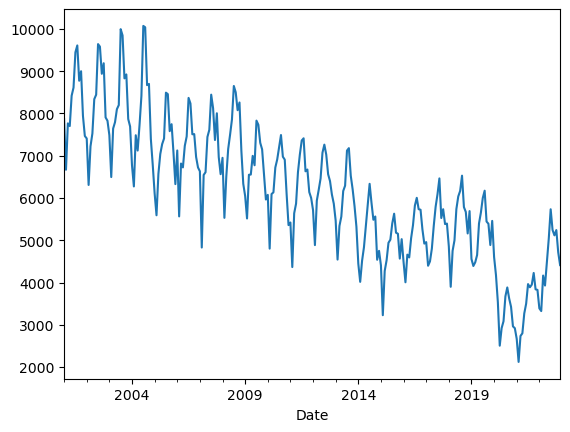

In [25]:
# Plot the data to observe the seasonal trend visually if possible
df_theft.plot();

From the plot above, there is definitely a seasonal trend with the data.

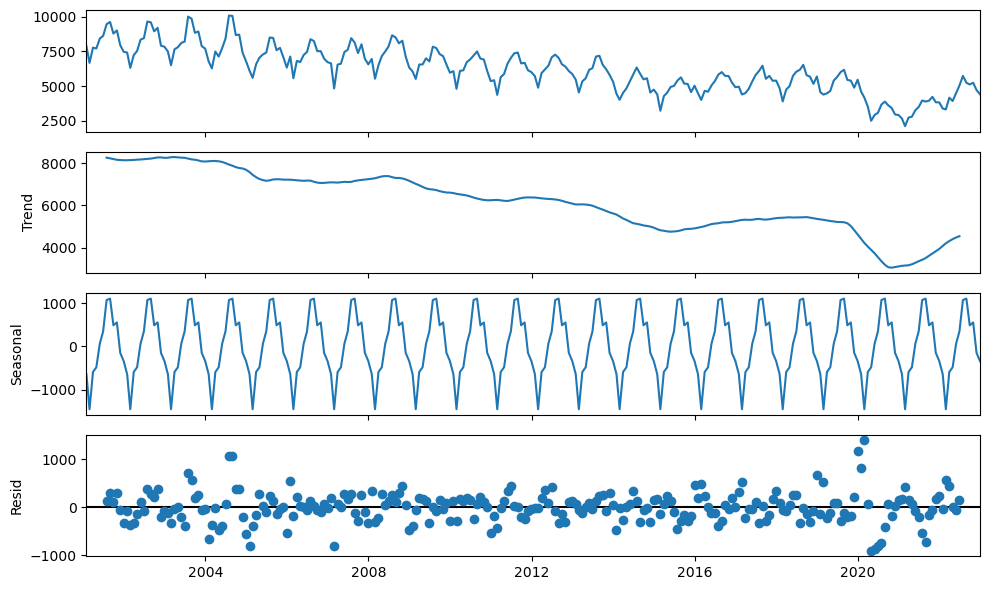

In [26]:
# Decompose the Time series to detect seasonality 
decomp_theft = tsa.seasonal_decompose(df_theft)
fig = decomp_theft.plot()
fig.set_size_inches(10,6)
fig.tight_layout();

Seasonal_decompose will always indicate some seasonality, noticed that the residual plot does not have any pattern which is a sign of seasonality. However, I will also need to consider how impactful the seasonal component is.

In [28]:
# How big is the seasonal component
seasonal_delta = decomp_theft.seasonal.max() - decomp_theft.seasonal.min()
# How big is the seasonal component relative to the time series?
print(f' The seasonal component is {seasonal_delta} which is ~ {seasonal_delta/(df_theft.max()-df_theft.min())*100:.2f}% of the variation in time series.')

 The seasonal component is 2549.988095238095 which is ~ 32.08% of the variation in time series.


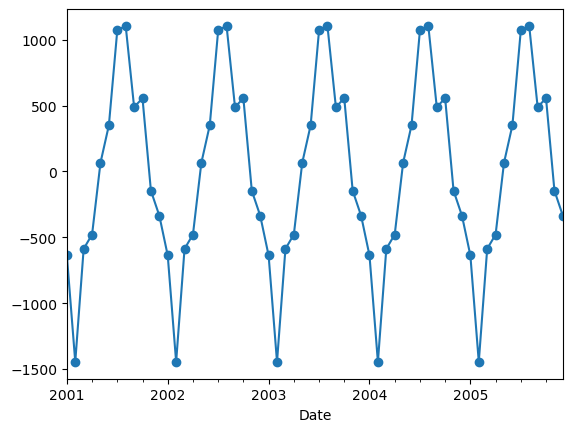

In [29]:
# Narrow down the date range of the plot
seasonal = decomp_theft.seasonal
ax = seasonal.loc['2001': '2005'].plot(marker = 'o')

There are 12 points between the peaks, indicating a seasonal period of 12 months. (m = 12)

### Check Stationarity

In [30]:
# Check for time series for stationarity
# Use adfuller to check to see if data is stationary
get_adfuller_results(df_theft)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.393935,13,250,0.58518,0.05,False


Data is not stationary

In [32]:
# use ndiffs and nsdiffs to determine how many differencing is needed to make data stationary. 
d = ndiffs(df_theft)
print (f'd = {d}')
# determine D
D = nsdiffs(df_theft, m = 12)
print (f'D = {D}')

d = 1
D = 0


1 differencing is sufficient to make data stationary

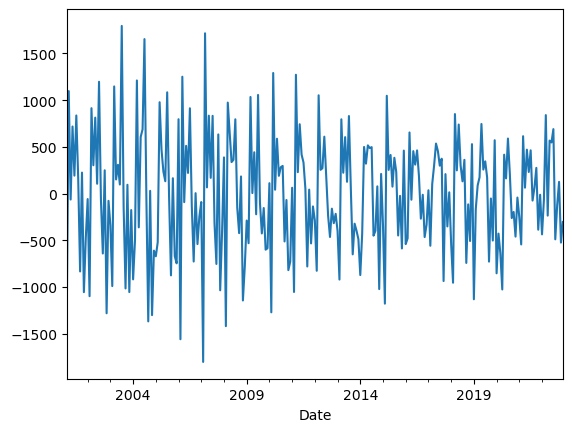

In [33]:
# apply 1 differencing
df_theft_diff = df_theft.diff().dropna()
df_theft_diff.plot();

In [34]:
# Use adfuller to check to see if data is stationary after differencing
get_adfuller_results(df_theft_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-3.953728,12,250,0.001673,0.05,True


Data is stationary after 1 differencing.

### Estimate Model Orders

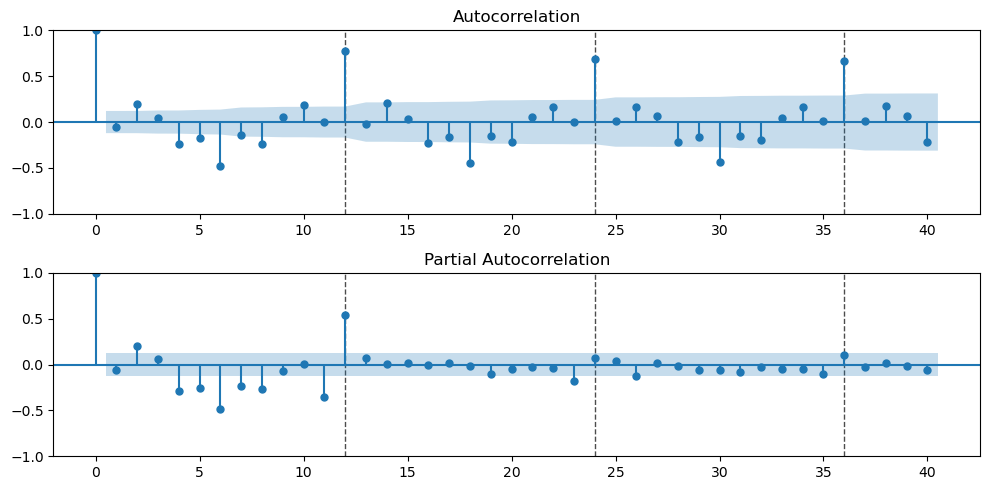

In [36]:
# Plot acf/pacf of the stationary data
plot_acf_pacf(df_theft_diff,annotate_seas=True,m=12);

For p and q : Both ACF and PACF plots show a gradually decrease and increase so I will start with an ARMA model with p=1 and q=1

For P and Q : seasonal lags in ACF stay consistently high and seasonal lags in PACF drop dramatically. I will start with an ARIMA model with P=1 and Q=0

**The initial seasonal model order: (1,1,1)(1,0,0)[12]**

### Train Test Split

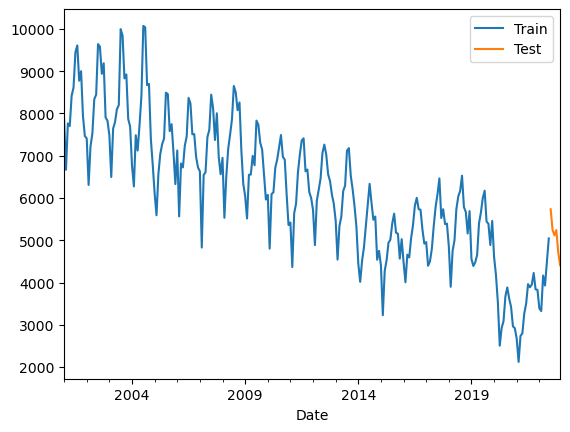

In [37]:
# Split the time series into training and test data (predict 6 months)
train, test = train_test_split(df_theft, test_size=6)
ax = train.plot(label='Train')
test.plot(ax = ax, label='Test')
ax.legend();

### Fit manual SARIMA model

In [38]:
# Orders for non seasonal components
p = 1
d = 1
q = 1
# Orders for seasonal components
P = 1
D = 0
Q = 0
m =12
# Fit the sarima model with above orders
sarima_theft = tsa.ARIMA(train, order=(p,d,q),seasonal_order=(P,D,Q,m)).fit()
# Obtain summary
sarima_theft.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  258
Model:             ARIMA(1, 1, 1)x(1, 0, [], 12)   Log Likelihood               -1897.686
Date:                           Tue, 09 Jan 2024   AIC                           3803.371
Time:                                   16:34:34   BIC                           3817.567
Sample:                               01-31-2001   HQIC                          3809.080
                                    - 06-30-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9639      0.171     -5.625      0.000      -1.300      -0.628
ma.L1          0.9700      0.155      6.253      0.000       0.666       1.274
ar.S.L12       0.7794      0.029     26.847      0.000       0.722       0.836
sigma2      1.376e+05   1.04e+04     13.256      0.000    1.17e+05    1.58e+05
===================================================================================
Ljung-Box (L1) (Q):                   9.32   Jarque-Bera (JB):                 4.44
Prob(Q):                              0.00   Prob(JB):                         0.11
Heteroskedasticity (H):               0.72   Skew:                            -0.07
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
# Make a forecast based on this model
df_forecast_theft = sarima_theft.get_forecast(steps=len(test)).summary_frame()

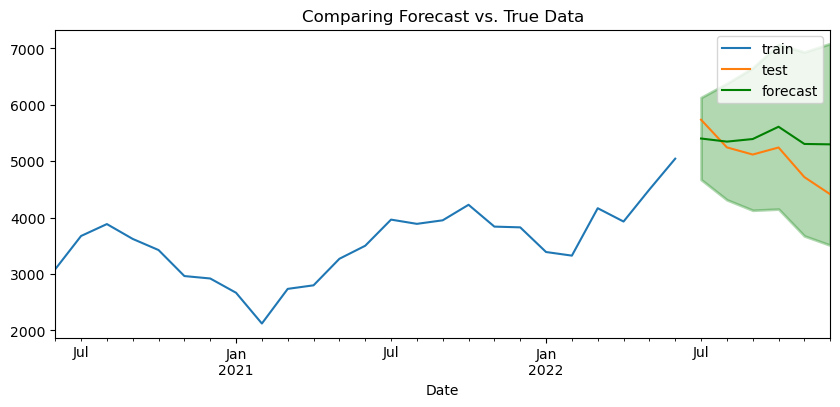

In [44]:
#Plot the forecasts versus the test data
plot_forecast(train, test, df_forecast_theft,n_train_lags=25);

The forecast catches some of the seasonal trends but does not anticipate a decrease at the very end.

In [43]:
# Obtain metrics for evaluation
regression_metrics_ts(test, df_forecast_theft['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 424.992
- MSE = 243,328.510
- RMSE = 493.283
- R^2 = -0.379
- MAPE = 8.77%


Noticed there is a negative R2 score which indicates there is something wrong with the model. 

### Tune with pmdarima's auto_arima

In [45]:
# Find best model using pmdarima's auto_arima¶
auto_model_theft = pm.auto_arima(train, seasonal=True, m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4050.524, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3791.710, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3914.631, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4048.603, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4050.805, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3774.214, Time=0.30 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3744.013, Time=0.76 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3743.960, Time=0.26 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3913.736, Time=0.09 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3742.901, Time=0.68 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3870.719, Time=0.29 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3754.859, Time=0.54 sec
 ARIMA(2,1,0)(1,0,2)[12] inte

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(1,1,0)(2,0,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(

 ARIMA(1,1,0)(2,0,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(1,0,2)[12]             : AIC=3753.387, Time=0.28 sec
 ARIMA(2,1,0)(1,0,2)[12]             : AIC=3743.206, Time=0.87 sec
 ARIMA(1,1,1)(1,0,2)[12]             : AIC=inf, Time=0.88 sec
 ARIMA(0,1,1)(1,0,2)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(2,1,1)(1,0,2)[12]             : AIC=inf, Time=0.90 sec

Best model:  ARIMA(1,1,0)(1,0,2)[12]          
Total fit time: 15.031 seconds


In [46]:
# The best model based on pmdarima's auto_arima's result
print(auto_model_theft.order)
print(auto_model_theft.seasonal_order)

(1, 1, 0)
(1, 0, 2, 12)


In [48]:
# Fit a model on training data with the best parameters from auto_arima
auto_sarima_theft =  tsa.ARIMA(train, order=auto_model_theft.order, seasonal_order=auto_model_theft.seasonal_order).fit()

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [49]:
auto_sarima_theft.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                     y   No. Observations:                  258
Model:             ARIMA(1, 1, 0)x(1, 0, [1, 2], 12)   Log Likelihood               -1865.634
Date:                               Tue, 09 Jan 2024   AIC                           3741.268
Time:                                       16:49:10   BIC                           3759.013
Sample:                                   01-31-2001   HQIC                          3748.404
                                        - 06-30-2022                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2251      0.046     -4.934      0.000      -0.315      -0.136
ar.S.L12       0.9778      0.008    120.054      0.000       0.962       0.994
ma.S.L12      -0.5771      0.059     -9.815      0.000      -0.692      -0.462
ma.S.L24      -0.1202      0.068     -1.758      0.079      -0.254       0.014
sigma2      1.038e+05   7353.346     14.120      0.000    8.94e+04    1.18e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                30.54
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.44
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
# Make a forecast based on this model
df_auto_forecast_theft = auto_sarima_theft.get_forecast(steps=len(test)).summary_frame()

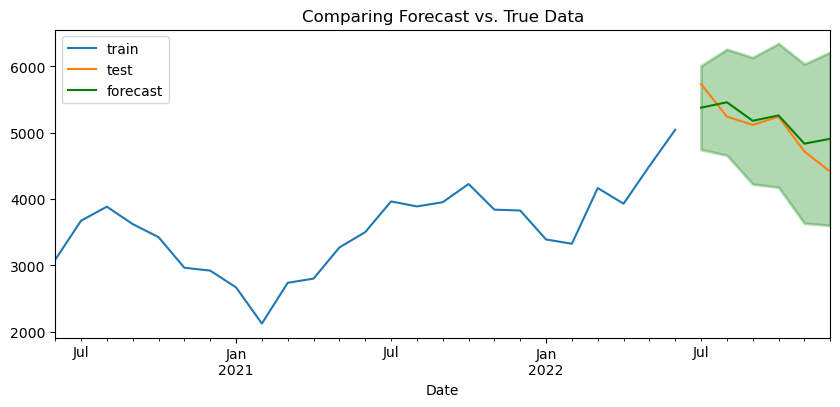

In [51]:
#Plot the forecasts versus the test data
plot_forecast(train, test, df_auto_forecast_theft,n_train_lags=25);

In [52]:
# Obtain metrics for evaluation
regression_metrics_ts(test, df_auto_forecast_theft['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 211.159
- MSE = 72,805.178
- RMSE = 269.824
- R^2 = 0.587
- MAPE = 4.27%


### Compare Manual and Tuned Models

Manual Model: 
- AIC:3803.371
- BIC:3817.567
- MAE = 424.992
- MSE = 243,328.510
- RMSE = 493.283
- R^2 = -0.379
- MAPE = 8.77%

Tuned Model:
- AIC:3741.268
- BIC:3759.013
- MAE = 211.159
- MSE = 72,805.178
- RMSE = 269.824
- R^2 = 0.587
- MAPE = 4.27%

Based on the forecast plots, the tuned model's predictions are closer to the true (test) values. It catches more trends than the manual model. The tuned model also has a lower AIC and BIC compared to the manual model. By looking at the evaluation metrics, the tuned model has better(lower) MAE, MSE, RMSE, and MAPE. Most importantly the manual model has a negative R2 score which indicates there is something wrong with the model. However, the tuned model has a positive R2 which is acceptable. By considering all of the above, the tuned model is better for this dataset and I will select the tuned model to be my final model to make future forecasts. 

### Future Forecast with Final Model

In [55]:
# Fit the final model using the entire Theft dataset
final_theft_model = tsa.ARIMA(df_theft,order=auto_model_theft.order,seasonal_order=auto_model_theft.seasonal_order).fit()

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


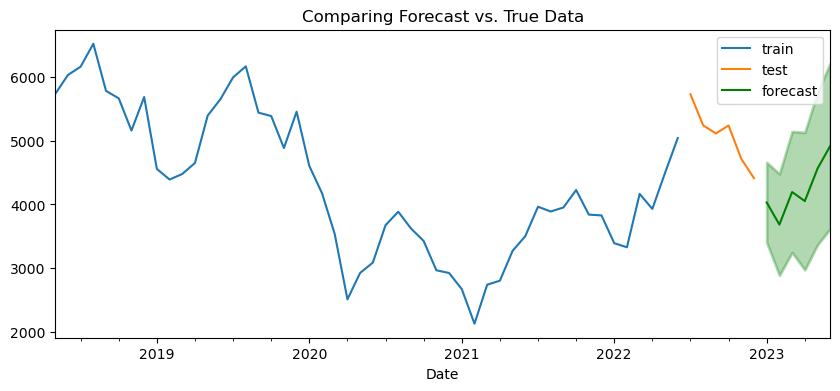

In [57]:
# Forcast Theft crime count 6 months into the future
forecast_theft = final_theft_model.get_forecast(len(test)).summary_frame()
plot_forecast(train, test, forecast_theft,n_train_lags=50);

In [126]:
# Check the starting and ending dates of the forecast
forecast_theft.index[0],forecast_theft.index[-1]

(Timestamp('2023-01-31 00:00:00'), Timestamp('2023-06-30 00:00:00'))

In [127]:
# Defining the starting value
starting_value = forecast_theft['mean'].iloc[0]
starting_value

4031.376190727666

In [128]:
# Defining the ending value
ending_value = forecast_theft['mean'].iloc[-1]
ending_value

4920.784852444844

In [129]:
change = ending_value - starting_value
print(f" Model forecast indicates that the crime counts of theft will increase by {change: .0f} over the forecast period.")

 Model forecast indicates that the crime counts of theft will increase by  889 over the forecast period.


In [130]:
perc_change = (change/starting_value)*100
print(f' The percent change of theft crime counts over the forecast period is {perc_change:.2f}%.')

 The percent change of theft crime counts over the forecast period is 22.06%.


---

## Crime Type: Assault

### Check for Seasonality

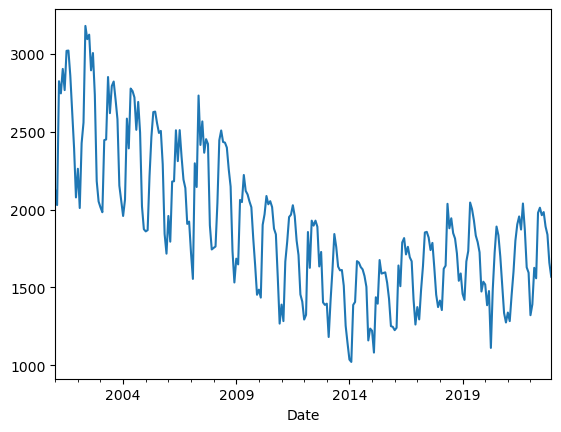

In [72]:
# Plot the data to observe the seasonal trend visually if possible
df_assault.plot();

From the plot above, there is definitely a seasonal trend with the data.

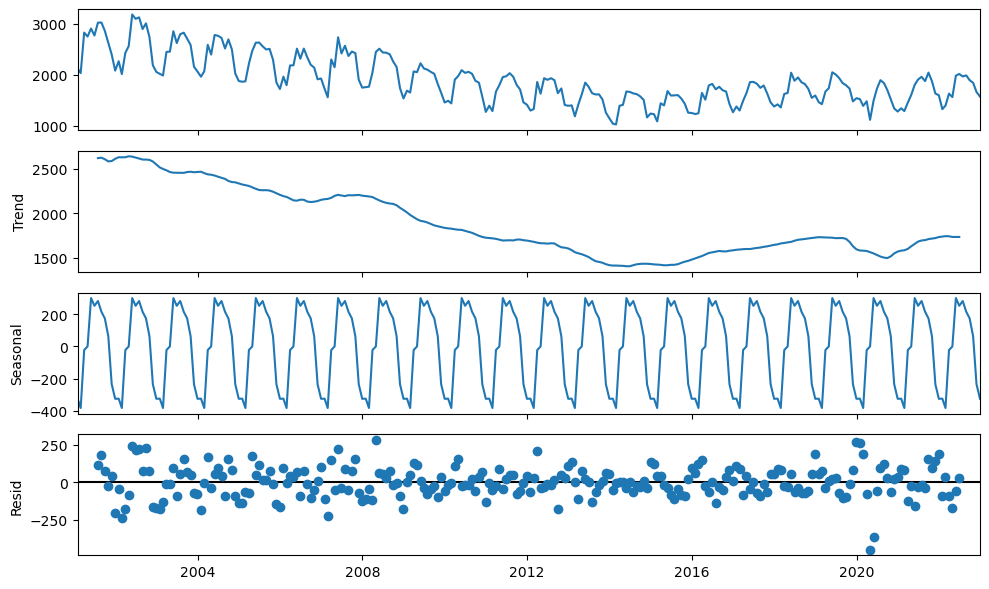

In [73]:
# Decompose the Time series to detect seasonality 
decomp_assault = tsa.seasonal_decompose(df_assault)
fig = decomp_assault.plot()
fig.set_size_inches(10,6)
fig.tight_layout();

In [74]:
# How big is the seasonal component
seasonal_delta = decomp_assault.seasonal.max() - decomp_assault.seasonal.min()
# How big is the seasonal component relative to the time series?
print(f' The seasonal component is {seasonal_delta} which is ~ {seasonal_delta/(df_assault.max()-df_assault.min())*100:.2f}% of the variation in time series.')

 The seasonal component is 684.8888888888888 which is ~ 31.75% of the variation in time series.


There is a seasonal component for approximately 31.75% of the total variation. Therefore, the model should have a seasonal component.

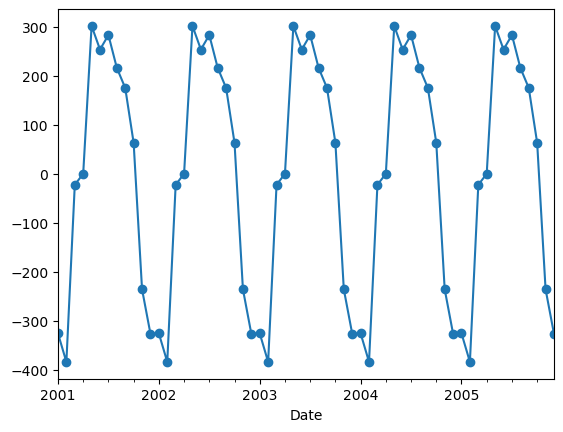

In [75]:
# Narrow down the date range of the plot
seasonal = decomp_assault.seasonal
ax = seasonal.loc['2001': '2005'].plot(marker = 'o')

There are 12 points between the peaks, indicating a seasonal period of 12 months. (m = 12)

### Check Stationarity

In [76]:
# Check for time series for stationarity
# Use adfuller to check to see if data is stationary
get_adfuller_results(df_assault)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.836624,15,248,0.362437,0.05,False


Data is not stationary.

In [77]:
# use ndiffs and nsdiffs to determine how many differencing is needed to make data stationary. 
d = ndiffs(df_assault)
print (f'd = {d}')
# determine D
D = nsdiffs(df_assault, m = 12)
print (f'D = {D}')

d = 1
D = 0


1 differencing is sufficient to make the data stationary.

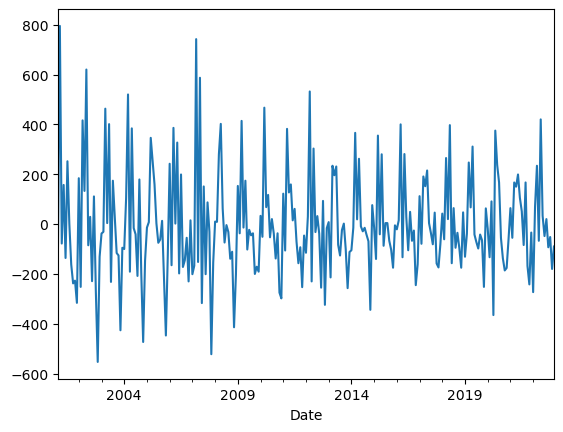

In [78]:
# apply 1 differencing
df_assault_diff = df_assault.diff().dropna()
df_assault_diff.plot();

In [79]:
# Use adfuller to check to see if data is stationary after differencing
get_adfuller_results(df_assault_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-3.936162,14,248,0.001784,0.05,True


Data is stationary after 1 differencing.

### Estimate Model Orders

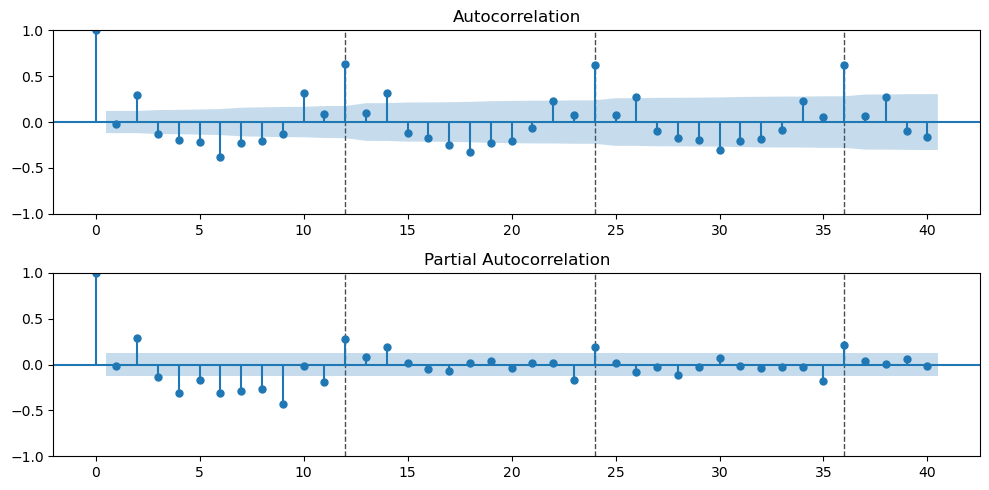

In [80]:
# Plot acf/pacf of the stationary data
plot_acf_pacf(df_assault_diff,annotate_seas=True,m=12);

For p and q : Both ACF and PACF plots show a gradually decrease and increase so I will start with an ARIMA model with p=1 and q=1

For P and Q : seasonal lags in both plots stays almost constant with very small change in PACF. Therefore, I will start with an SARIMA model with P=1, Q=1.

**The initial seasonal model order: (1,1,1)(1,0,1)[12]**

### Train Test Split

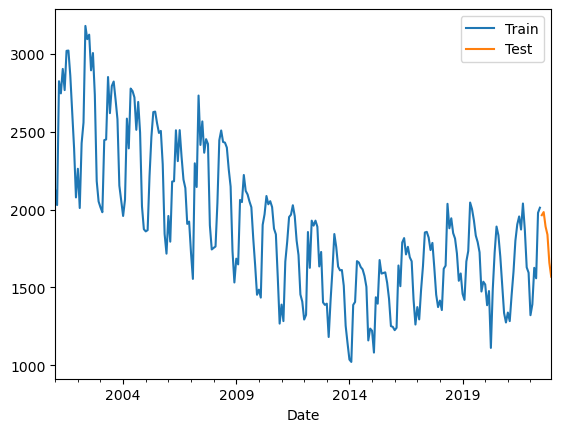

In [81]:
# Split the time series into training and test data (predict 6 months)
train, test = train_test_split(df_assault, test_size=6)
ax = train.plot(label='Train')
test.plot(ax = ax, label='Test')
ax.legend();

### Fit manual SARIMA model

In [82]:
# Orders for non seasonal components
p = 1
d = 1
q = 1
# Orders for seasonal components
P = 1
D = 0
Q = 1
m =12
# Fit the sarima model with above orders
sarima_assault = tsa.ARIMA(train, order=(p,d,q),seasonal_order=(P,D,Q,m)).fit()
# Obtain summary
sarima_assault.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  258
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1609.728
Date:                          Tue, 09 Jan 2024   AIC                           3229.456
Time:                                  19:25:42   BIC                           3247.202
Sample:                              01-31-2001   HQIC                          3236.592
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9024      0.045     20.160      0.000       0.815       0.990
ma.L1         -0.9993      0.010    -96.668      0.000      -1.020      -0.979
ar.S.L12       0.9914      0.006    159.029      0.000       0.979       1.004
ma.S.L12      -0.7788      0.075    -10.347      0.000      -0.926      -0.631
sigma2      1.632e+04   1707.438      9.561      0.000     1.3e+04    1.97e+04
===================================================================================
Ljung-Box (L1) (Q):                  18.23   Jarque-Bera (JB):                19.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
# Make a forecast based on this model
df_forecast_assault = sarima_assault.get_forecast(steps=len(test)).summary_frame()

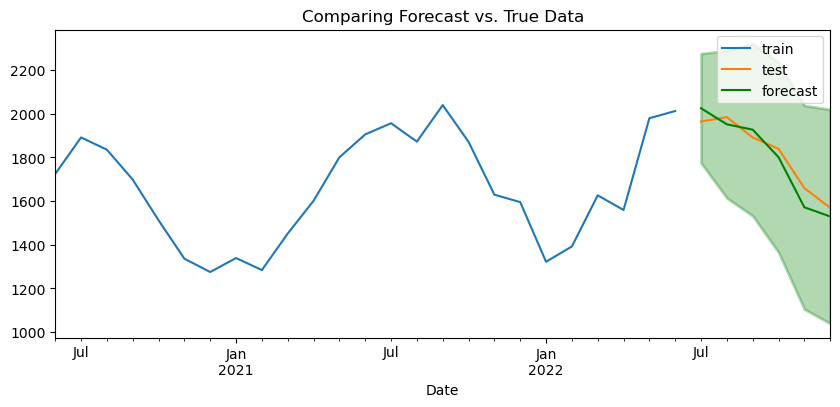

In [84]:
#Plot the forecasts versus the test data
plot_forecast(train, test, df_forecast_assault,n_train_lags=25);

The manual model forecast catches most of the true value trends. 

In [85]:
# Obtain metrics for evaluation
regression_metrics_ts(test, df_forecast_assault['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 49.168
- MSE = 2,796.401
- RMSE = 52.881
- R^2 = 0.882
- MAPE = 2.76%


### Tune with pmdarima's auto_arima

In [86]:
# Find best model using pmdarima's auto_arima¶
auto_model_assault = pm.auto_arima(train, seasonal=True, m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3483.860, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3318.021, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3405.065, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3481.861, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3485.758, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3404.125, Time=0.09 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=3337.645, Time=0.05 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=3313.233, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=3462.085, Time=0.06 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=3

In [88]:
# The best model based on pmdarima's auto_arima's result
print(auto_model_assault.order)
print(auto_model_assault.seasonal_order)

(4, 1, 0)
(2, 0, 2, 12)


In [89]:
# Fit a model on training data with the best parameters from auto_arima
auto_sarima_assault =  tsa.ARIMA(train, order=auto_model_assault.order, seasonal_order=auto_model_assault.seasonal_order).fit()

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [90]:
auto_model_assault.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  258
Model:             SARIMAX(4, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -1586.056
Date:                                 Tue, 09 Jan 2024   AIC                           3192.111
Time:                                         19:33:58   BIC                           3227.602
Sample:                                     01-31-2001   HQIC                          3206.384
                                          - 06-30-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0082      0.517      0.016      0.987      -1.005       1.021
ar.L1         -0.4435      0.059     -7.578      0.000      -0.558      -0.329
ar.L2         -0.2796      0.066     -4.246      0.000      -0.409      -0.151
ar.L3         -0.2493      0.063     -3.953      0.000      -0.373      -0.126
ar.L4         -0.1597      0.063     -2.525      0.012      -0.284      -0.036
ar.S.L12       1.3955      0.212      6.597      0.000       0.981       1.810
ar.S.L24      -0.4030      0.210     -1.917      0.055      -0.815       0.009
ma.S.L12      -1.3307      0.194     -6.849      0.000      -1.712      -0.950
ma.S.L24       0.5553      0.149      3.730      0.000       0.264       0.847
sigma2      1.162e+04    948.495     12.249      0.000    9759.295    1.35e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                23.78
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -0.13
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
# Make a forecast based on this model
df_auto_forecast_assault = auto_sarima_assault.get_forecast(steps=len(test)).summary_frame()

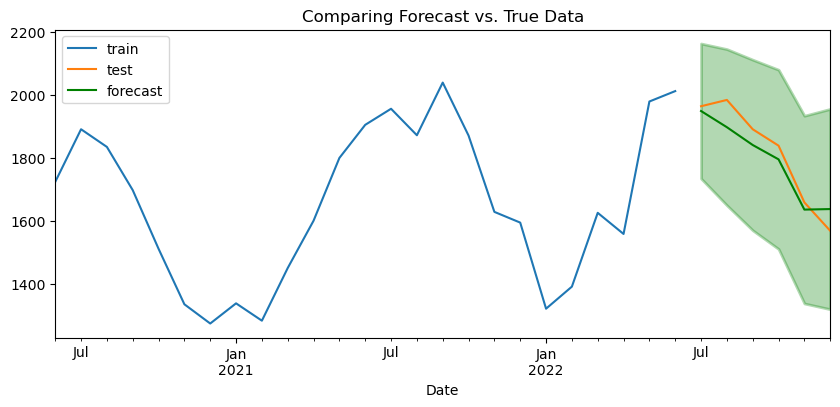

In [92]:
#Plot the forecasts versus the test data
plot_forecast(train, test, df_auto_forecast_assault,n_train_lags=25);

In [95]:
# Obtain metrics for evaluation
regression_metrics_ts(test, df_auto_forecast_assault['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 47.795
- MSE = 2,894.408
- RMSE = 53.800
- R^2 = 0.878
- MAPE = 2.65%


### Compare Manual and Tuned Models

Manual Model:
- AIC:3229.456
- BIC:3247.202
- MAE = 49.168
- MSE = 2,796.401
- RMSE = 52.881
- R^2 = 0.882
- MAPE = 2.76%

Tuned Model:
- AIC:3192.111
- BIC:3227.602
- MAE = 47.795
- MSE = 2,894.408
- RMSE = 53.800
- R^2 = 0.878
- MAPE = 2.65%

Based on the forecast plots, the manual model's predictions are closer to the true (test) values. It catches more trends than the tuned model. Although the tuned model has a lower AIC and BIC, the manual model has better MSE, RMSE, and R2. The manual model is also a simpler model compared to the tuned model. By considering all of the above, the two models preformed very close and it is hard to say which one performs better than the other, therefore, I will select the simpler model(manual model) to be my final model. 

### Future Forecast with Final Model

In [106]:
# Fit final model on the full dataset
# Order for non seasonal components
p = 1
d = 1
q = 1
# Orders for seasonal components
P = 1
D = 0
Q = 1
m =12
# Fit the sarima model with above orders
final_assault_model = tsa.ARIMA(df_assault, order=(p,d,q),seasonal_order=(P,D,Q,m)).fit()

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


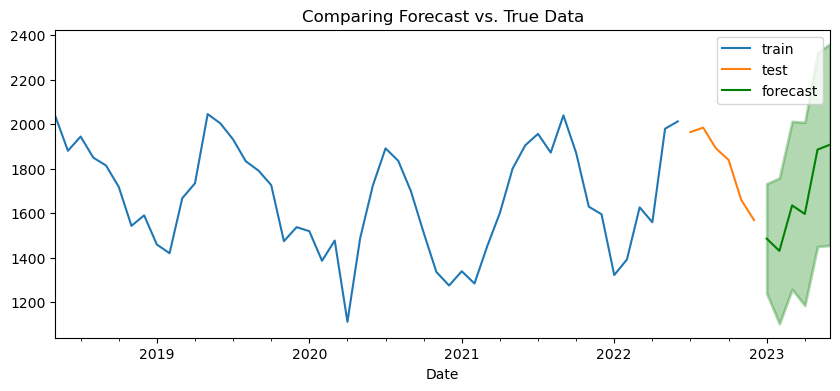

In [107]:
# Forcast assault crime count 6 months into the future
forecast_assault = final_assault_model.get_forecast(len(test)).summary_frame()
plot_forecast(train, test, forecast_assault,n_train_lags=50);

In [119]:
# Check the starting and ending dates of the forecast
forecast_assault.index[0],forecast_assault.index[-1]

(Timestamp('2023-01-31 00:00:00'), Timestamp('2023-06-30 00:00:00'))

In [121]:
# Defining the starting value
starting_value1 = forecast_assault['mean'].iloc[0]
starting_value1

1485.6446709781042

In [122]:
# Defining the ending value
ending_value1 = forecast_assault['mean'].iloc[-1]
ending_value1

1907.9404611935609

In [123]:
change1 = ending_value1 - starting_value1
print(f" Model forecast indicates that the crime counts of assault will increase by {change1: .0f} over the forecast period.")

 Model forecast indicates that the crime counts of assault will increase by  422 over the forecast period.


In [124]:
perc_change1 = (change1/starting_value1)*100
print(f' The percent change of assault crime counts over the forecast period is {perc_change1:.2f}%.')

 The percent change of assault crime counts over the forecast period is 28.43%.


---

# Final Evaluation

**Of the two crimes, which is forecasted to have the highest monthly count of crimes at the end of the forecast?**

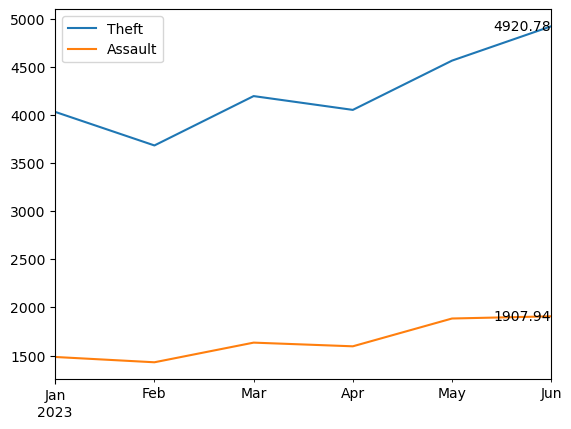

In [118]:
# plot the 6 months forecast of monthly crime counts for both theft and assault
ax = forecast_theft['mean'].plot(label='Theft')
forecast_assault['mean'].plot(ax=ax, label='Assault')

last_date_theft = forecast_theft['mean'].index[-1]
last_value_theft = forecast_theft['mean'].iloc[-1]

last_date_assault = forecast_assault['mean'].index[-1]
last_value_assault = forecast_assault['mean'].iloc[-1]

plt.text(last_date_theft, last_value_theft, f'{last_value_theft:.2f}', va='center', ha='right')

plt.text(last_date_assault, last_value_assault, f'{last_value_assault:.2f}', va='center', ha='right')

plt.legend()
plt.show()

Based on the model's predicitons, theft will have the highest monthly counts of crime at the end of the forecast.

**Of the two crimes, which is forecasted to have the highest net change by the end of the forecast?**

In [131]:
change1 = ending_value1 - starting_value1
print(f" Model forecast indicates that the crime counts of assault will increase by {change1: .0f} over the forecast period.")
change = ending_value - starting_value
print(f" Model forecast indicates that the crime counts of theft will increase by {change: .0f} over the forecast period.")

 Model forecast indicates that the crime counts of assault will increase by  422 over the forecast period.
 Model forecast indicates that the crime counts of theft will increase by  889 over the forecast period.


Based on the model's predictions, theft will have the highest net change by the end of the forecast.

**Of the two crimes, which is forecasted to have the highest percent change by the end of the forecast?**

In [132]:
perc_change1 = (change1/starting_value1)*100
print(f' The percent change of assault crime counts over the forecast period is {perc_change1:.2f}%.')
perc_change = (change/starting_value)*100
print(f' The percent change of theft crime counts over the forecast period is {perc_change:.2f}%.')

 The percent change of assault crime counts over the forecast period is 28.43%.
 The percent change of theft crime counts over the forecast period is 22.06%.


Based on the model's predictions, assault will ahve the highest percent change by the end of the forecast.

# Final Recommendations

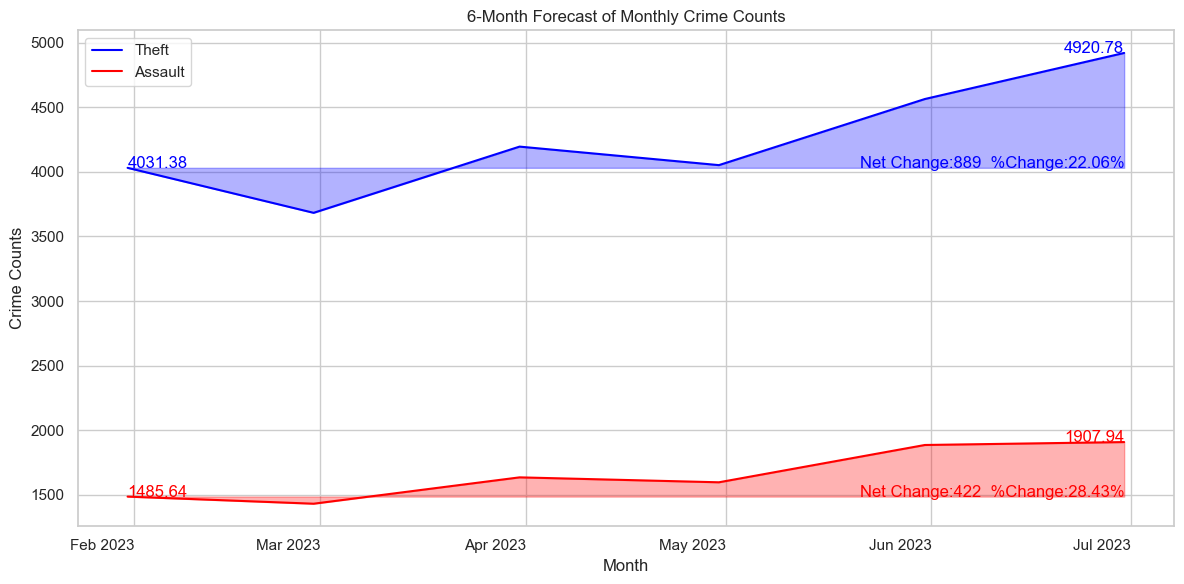

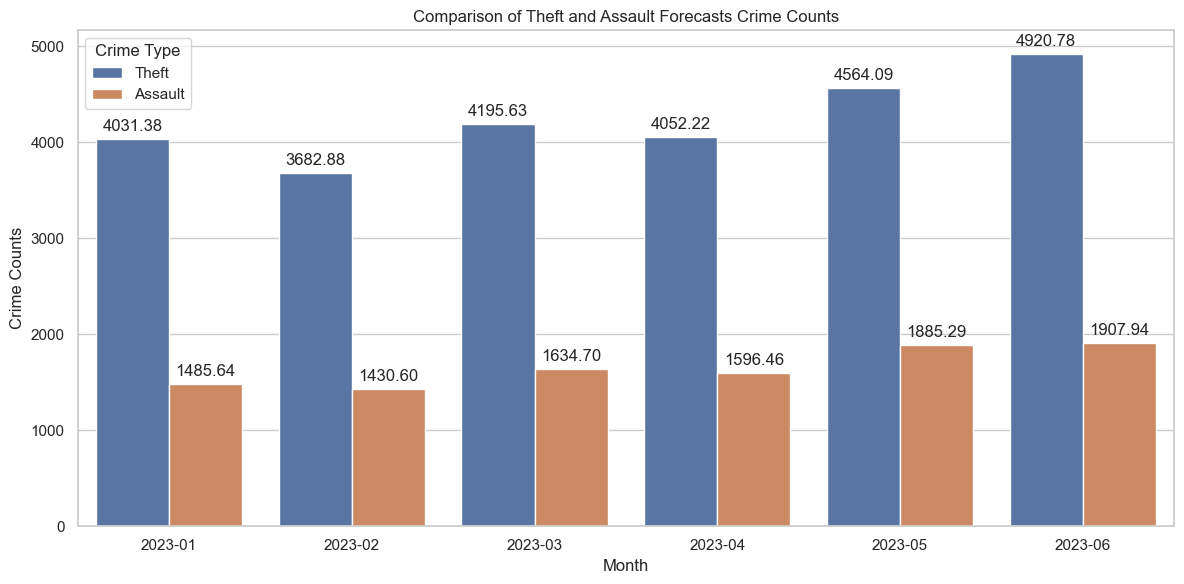

In [204]:
# Plot forecast crime counts for theft and assault, annote %change and net change
plt.figure(figsize=(12, 6))

ax = forecast_theft['mean'].plot(label='Theft', color='blue',x_compat=True)
forecast_assault['mean'].plot(ax=ax, label='Assault', color='red')

first_date_theft = forecast_theft['mean'].index[0]
first_value_theft = forecast_theft['mean'].iloc[0]
last_date_theft = forecast_theft['mean'].index[-1]
last_value_theft = forecast_theft['mean'].iloc[-1]
plt.text(last_date_theft, last_value_theft, f'{last_value_theft:.2f}', ha='right', color='blue')
plt.text(first_date_theft, first_value_theft, f'{first_value_theft:.2f}', color='blue')

first_date_assault = forecast_assault['mean'].index[0]
first_value_assault = forecast_assault['mean'].iloc[0]
last_date_assault = forecast_assault['mean'].index[-1]
last_value_assault = forecast_assault['mean'].iloc[-1]
plt.text(last_date_assault, last_value_assault, f'{last_value_assault:.2f}', ha='right', color='red')
plt.text(first_date_assault, first_value_assault, f'{first_value_assault:.2f}', color='red')

starting_value_theft = forecast_theft['mean'].iloc[0]
change_theft = last_value_theft - starting_value_theft
perc_change_theft = (change_theft / starting_value_theft) * 100

starting_value_assault = forecast_assault['mean'].iloc[0]
change_assault = last_value_assault - starting_value_assault
perc_change_assault = (change_assault / starting_value_assault) * 100

ax.fill_between(forecast_theft.index, starting_value_theft, forecast_theft['mean'], color='blue', alpha=0.3)
plt.text(last_date_theft, starting_value_theft, f'Net Change:{change_theft:.0f}  %Change:{perc_change_theft:.2f}%', ha='right', color='blue')

ax.fill_between(forecast_assault.index, starting_value_assault, forecast_assault['mean'], color='red', alpha=0.3)
plt.text(last_date_assault, starting_value_assault, f'Net Change:{change_assault:.0f}  %Change:{perc_change_assault:.2f}%', ha='right', color='red')

plt.title('6-Month Forecast of Monthly Crime Counts')
plt.xlabel('Month')
plt.ylabel('Crime Counts')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

# Comparing Theft and Assault forecast crime counts
dates = forecast_theft.index

plot_data = pd.DataFrame({
    'Date': forecast_theft.index,
    'Theft': forecast_theft['mean'].values,
    'Assault': forecast_assault['mean'].values
})

plot_data_melted = plot_data.melt('Date', var_name='Crime Type', value_name='Forecast')
plot_data_melted['Date'] = plot_data_melted['Date'].dt.to_period('M').astype(str)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Date', y='Forecast', hue='Crime Type', data=plot_data_melted)

plt.title('Comparison of Theft and Assault Forecasts Crime Counts')
plt.xlabel('Month')
plt.ylabel('Crime Counts')
plt.xticks(rotation=0)  
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')
plt.tight_layout()
plt.show()

In response to the predictive analysis indicating a significant rise in crime for the upcoming months in Chicago, with theft expected to increase by 22% to approximately 4,922 incidents and assault by 28% to about 1,908 incidents by June 2023, it is imperative for law enforcement to strategically allocate resources. This peak, representing an increase of 889 theft cases and 422 assault cases from January, necessitates a focused approach.
    
The Chicago Police Department should prioritize enhanced patrols and targeted deployment in historically affected areas, especially during the high-risk month of June. Equally important is intensifying community engagement and awareness programs to prepare and inform the public. 

The seasonal trends of both crimes are similar, with February typically experiencing the lowest monthly crime rates. Therefore, it would be strategic for law enforcement to reallocate resources during February, focusing on training new officers and preparing for the expected increase in criminal activity in the subsequent months.

Continuous monitoring of these crime trends and an adaptable strategy will be key to effectively manage and mitigate the expected rise in criminal activities, ensuring public safety and community well-being.